# How and Why does Self Attention Work? 

## Stacking Non-Linear Transformations

The prevailing paradigm in machine learning is to stack sets of non-linear transformation, initially on the input data, and then on the outputs successively. Each transformation is called a layer. "Deep" architectures are so called because they have many layers -- for example, the GPT-3 model trained at OpenAI had 96 layers in total. 

Many of the key breakthroughs in recent years have focused on resolving the problems that crop up while training deep architectures. I have covered a few of these in previous posts, such as [Batch Normalization](...) and [Dropout](...).

The earliest deep-learning architecture was what is now called a Feed-Forward Network, which in its current mature formulation, consists of a linear operation followed by a non-linear activation function $(\sigma)$ such as ReLU (Rectified Linear Unit).

$$
f(\bold{x}) = \sigma(\bold{Wx} + b)
$$


<img src="nn.svg" alt="Feed Forward Network" style="width:500px;"/>

Another popular architecture used primarily in computer vision is the Convolutional Neural Network (CNN), whose basic transformation is the convolution followed by an activation function. The idea here is that the model can learn to detect features in an image by performing non-linear transformations on small patches of the image. Then, just like the basic Feed-Forward network, the same operation can be performed on the outputs successively.


<img src="cnn.svg" alt="Feed Forward Network" style="width:800px;"/>

I won't go into to much detail on these here.


## A New Transformation

The idea of self-attention developed out of the sequence-to-sequence model architectures which were used primarily for machine translation. Here, the goal was to learn a single representation for an input sentence ("encode"), then use it to generate a translation ("decode").

It however proved difficult to compress the information needed to translate a long sentence into a single representation. 

Bahadanau et. al. (2014) introduced the concept of attention -- the model could learn to use parts of the input sentence ("attend") directly while decoding rather than rely solely on the learnt representation. Parikh et al. (2016) realized that the attention operation itself could be used for NLP tasks such as entailment. Lin et al. (2017) introduced the concept of self-attention to perform a variety of NLP tasks. 

In my earlier post on [Nadaraya-Watson Regression](...), we saw how this classic non-parametric technique can be interpreted as an early form of attention. 

Vaswani el al. (2017) realized that the self-attention mechanism could be used as the basic non-linear transformation for sequences of variable length. This also allowed the model to process tokens in parallel by incorporating positional information (check out my post on positional embeddings [here](...)). By avoiding having to explicitly process each token in sequence, it became possible to train much deeper networks. 




## So What Exactly is Self Attention?



TODO


## Let's See If it Works

Let's train a sentiment classifier. For our dataset, we will be using Yelp review dataset with GloVE embeddings. Our baseline model is a simple feedforward network that uses an average of the word embeddings. The candidate model will use an additional self-attention layer. 



### Let's start by loading the dataset

In [55]:
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

import random

## loading corpus
#raw_train_data = [(' '.join(movie_reviews.words(fileid)), category)
#             for category in movie_reviews.categories()
#             for fileid in movie_reviews.fileids(category)]
#random.shuffle(raw_train_data)  #in-place shuffle

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/vikram/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [3]:
from datasets import load_dataset
import tensorflow_datasets as tfds

# Load the SST-2 dataset
#raw_train_data, raw_test_data = tfds.load("glue/sst2", split=["train", "test"])
# Load IMDb dataset from Hugging Face
raw_train_data, raw_test_data = load_dataset("imdb", split=["train", "test"])
print(len(raw_train_data), len(raw_test_data))

/Users/vikram/dev/xjax/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


25000 25000


Let's look at some reviews

In [4]:
from IPython.display import display, HTML

display(HTML("""
<style>
    .custom-paragraph {
        width: 600px;
        margin: auto;
        line-height: 1.6;
    }
</style>
"""))

In [5]:
from itertools import islice
n_samples = 5
samples = list(islice(raw_train_data, n_samples))
#samples = list(raw_train_data.take(n_samples).cache())
html = ""
for d in samples:
    text = d['text']
    label = "Positive" if d['label'] == 1 else "Negative"
    html += f"""<div class="custom-paragraph">
              <p><b>[{label}]</b> {text}</p>
             </div>"""
display(HTML(html))

Preprocess the data

In [6]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/vikram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
import re
from collections import Counter

def clean_paragraph(text):
    # Keep only alphanumeric characters, punctuation, and spaces.
    text = text.lower()
    text = re.sub(r'<br\s*/?>', ' ', text, flags=re.IGNORECASE) # Remove <br/> tags
    text = re.sub(r'[-]', ' ', text, flags=re.IGNORECASE) # Replace hyphens with spaces
    text = re.sub(r'[.]', ' . ', text) # Pad dots and periods
    cleaned_text = re.sub(r'[^a-z0-9\s\.,!?;:-]', '', text) # Keep only alphanumeric and punctuation
    return cleaned_text

def process_raw_data(raw_data):
    word_counts = Counter()
    processed_data = []
    for i, item in enumerate(raw_data):
        print(f"Processing item {i}", end="\r")
        # Split into sentences
        text = item['text'] #.numpy().decode('utf-8')
        #text = clean_paragraph(item[0])
        #label = 0 if item[1] == 'neg' else 1
        label = item['label']
        # Tokenize
        tokens = word_tokenize(text)
        word_counts.update(tokens)
        processed_data.append((tokens, label))
        # Update indices
    sorted_counts = word_counts.most_common()
    return sorted_counts, processed_data


train_word_counts, clean_train_data = process_raw_data(raw_train_data)
#test_word_counts, clean_test_data = process_raw_data(raw_test_data)

In [8]:
len(clean_train_data[0][0])

335

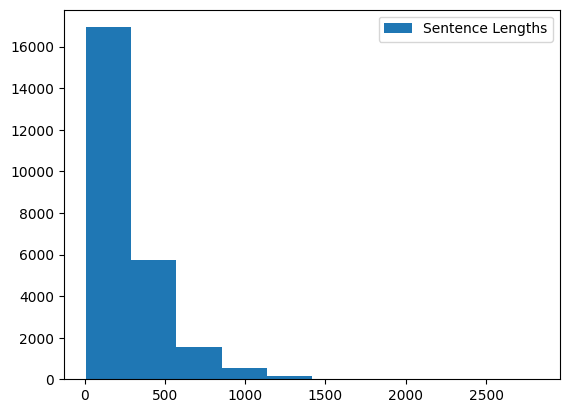

In [9]:
import matplotlib.pyplot as plt 

sentence_lengths = [len(l[0]) for l in clean_train_data ]

plt.hist(sentence_lengths)
plt.legend(['Sentence Lengths'])
plt.show()

In [10]:
VOCAB_SIZE = 20000
vocab = [ '<UNK>', '<PAD>' ]
vocab += [ t[0] for t in train_word_counts[:VOCAB_SIZE] ]
VOCAB_SIZE = len(vocab)

In [11]:
tok_to_idx = {}
for i, tok in enumerate(vocab): 
    tok_to_idx[tok] = i

Let's build the dataset

In [16]:
import jax
import jax.numpy as jnp

SEQUENCE_LENGTH = 200

def get_idxs(tokens):
    # Substitute tokens with indices
    idxs = []
    for tok in tokens:
        if tok in tok_to_idx:
            idxs.append(tok_to_idx[tok])
        else:
            idxs.append(tok_to_idx['<UNK>'])

    return idxs


def split_into_chunks(idxs, chunk_size):
    chunks =  [idxs[i:i+chunk_size] for i in range (0, len(idxs), chunk_size)]
    for c in chunks:
        while len(c) < chunk_size:
            c.append(tok_to_idx['<PAD>'])
    return chunks


def generate_dataset(data):

    X = []
    Y = []
    for i, x in enumerate(data):
        print(f"Processing {i}", end="\r")
        tokens = x[0]
        label = x[1]
        idxs = get_idxs(tokens)
        if len(idxs) < SEQUENCE_LENGTH: 
            idxs += [0]*(SEQUENCE_LENGTH - len(idxs))
        elif len(idxs) > SEQUENCE_LENGTH:
            idxs = idxs[:SEQUENCE_LENGTH]

        X.append(idxs)
        Y.append(label)
    X = jnp.array(X)
    Y = jnp.array(Y)
    return X, Y


X_train, Y_train = generate_dataset(clean_train_data)
print(X_train.shape, Y_train.shape)
#X_test, Y_test = generate_dataset(clean_test_data)
#print(X_test.shape, Y_test.shape)

(25000, 200) (25000,)


In [39]:
import keras

vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(X_train, Y_train), (X_val, Y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(X_train), "Training sequences")
print(len(X_val), "Validation sequences")
X_train = keras.utils.pad_sequences(X_train, maxlen=maxlen)
X_val = keras.utils.pad_sequences(X_val, maxlen=maxlen)

X_train = jnp.array(X_train)
X_train.shape

25000 Training sequences
25000 Validation sequences


(25000, 200)

In [49]:
import jax
import flax
import jax.numpy as jnp
from flax import linen as nn
from typing import Any


def sinusoidal_init(max_len=2048, min_scale=1.0, max_scale=10000.0):
  """1D Sinusoidal Position Embedding Initializer.

  Args:
      max_len: maximum possible length for the input.
      min_scale: float: minimum frequency-scale in sine grating.
      max_scale: float: maximum frequency-scale in sine grating.

  Returns:
      output: init function returning `(1, max_len, d_feature)`
  """

  def init(key, shape, dtype=np.float32):
    """Sinusoidal init."""
    del key, dtype
    d_feature = shape[-1]
    pe = np.zeros((max_len, d_feature), dtype=np.float32)
    position = np.arange(0, max_len)[:, np.newaxis]
    scale_factor = -np.log(max_scale / min_scale) / (d_feature // 2 - 1)
    div_term = min_scale * np.exp(np.arange(0, d_feature // 2) * scale_factor)
    pe[:, : d_feature // 2] = np.sin(position * div_term)
    pe[:, d_feature // 2 : 2 * (d_feature // 2)] = np.cos(position * div_term)
    pe = pe[np.newaxis, :, :]  # [1, max_len, d_feature]
    return jnp.array(pe)

  return init

class TransformerEncoderBlock(nn.Module):
    hidden_dim: int
    num_heads: int
    mlp_dim: int

    def setup(self):
        self.attention = nn.SelfAttention(
            num_heads=self.num_heads,
            qkv_features=self.hidden_dim
        )
        self.mlp = nn.Sequential([
            nn.Dense(self.mlp_dim),
            nn.gelu,
            nn.Dense(self.hidden_dim)
        ])
        self.layernorm1 = nn.LayerNorm()
        self.layernorm2 = nn.LayerNorm()
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)

    def __call__(self, x):
        # Self-attention block
        residual = x
        x = self.attention(x)
        #x = self.dropout1(x)
        x = self.layernorm1(x + residual)

        # MLP block
        residual = x
        x = self.mlp(x)
        #x = self.dropout2(x)
        return self.layernorm2(x + residual)

class SentimentTransformer(nn.Module):
    max_seq_len: int 
    hidden_dim: int
    num_heads: int
    mlp_dim: int
    num_layers: int
    num_classes: int
    pretrained_embeddings: jnp.ndarray

    def setup(self):
        self.embedding = nn.Embed(
            num_embeddings=self.pretrained_embeddings.shape[0],
            features=self.hidden_dim,
            #embedding_init=lambda *_: self.pretrained_embeddings,
        )
        self.pos_embedding = nn.Embed(
            num_embeddings = self.max_seq_len,
            features=self.hidden_dim,
        )
        self.encoder_layers = [
            TransformerEncoderBlock(
                hidden_dim=self.hidden_dim,
                num_heads=self.num_heads,
                mlp_dim=self.mlp_dim
            ) for _ in range(self.num_layers)
        ]
        self.dense = nn.Dense(256)
        self.classifier = nn.Dense(self.num_classes)

    def __call__(self, inputs):
        outputs = {}
        # Embedding lookup
        #x = jax.lax.stop_gradient(self.embedding(inputs))
        x = self.embedding(inputs)

        # Calculate positional embeddings
        positions = jnp.arange(self.max_seq_len)
        pos_x = self.pos_embedding(positions)
        pos_x = jnp.expand_dims(pos_x, axis=0)
        pos_x = jnp.repeat(pos_x, repeats=x.shape[0], axis=0)

        x = x + pos_x
        
        # Transformer encoder blocks
        for encoder in self.encoder_layers:
            x = encoder(x)
        
        # Global average pooling
        x = jnp.mean(x, axis=1)
        #x = jnp.reshape(x, (x.shape[0], -1)) # b x ld
        x = self.dense(x)
        
        # Classification layer
        logits = self.classifier(x)
        return logits, outputs



Let's define the baseline model

In [47]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax

class EmbeddingModel(nn.Module):
    embed_matrix: jnp.ndarray  # Preloaded pretrained embeddings
    d: int
    vocab_size: int
    num_classes: int

    def setup(self):
        self.embedding_layer = nn.Embed(
            num_embeddings=self.vocab_size,
            features=self.d,
            embedding_init=lambda *_: self.embed_matrix
        )
        self.dense_layer = nn.Dense(features=self.num_classes)

    def __call__(self, x):
        outputs = {}
        # Embed the input tokens
        x = self.embedding_layer(x)
        #x = jax.lax.stop_gradient(self.embedding_layer(x))
        #x = jnp.mean(x, axis=1)
        seq_len = x.shape[1]
        n = 2
        #n_gram_avgs = [
        #    jnp.mean(x[:, i:i+n], axis=1) for i in range(seq_len - n + 1)
        #]
        #x = jnp.stack(n_gram_avgs, axis=1)

        x = jnp.reshape(x, (x.shape[0], -1))
        logits = self.dense_layer(x)
        return logits, outputs


class TransformerModel(nn.Module):
    max_seq_len: int
    embed_matrix: jnp.ndarray  # Preloaded pretrained embeddings
    d: int
    vocab_size: int
    num_classes: int

    @nn.compact
    def __call__(self, x):
        outputs = {}
        # Embed the input tokens
        embedding_layer = nn.Embed(
            num_embeddings=self.vocab_size,
            features=100,
            #embedding_init=lambda *_: self.embed_matrix
        )
        x = jax.lax.stop_gradient(embedding_layer(x))

        # Calculate positional embeddings

        pos_embedding = nn.Embed(
            num_embeddings = self.max_seq_len,
            features=100,
        )

        positions = jnp.arange(self.max_seq_len)
        pos_x = pos_embedding(positions)
        pos_x = jnp.expand_dims(pos_x, axis=0)
        pos_x = jnp.repeat(pos_x, repeats=x.shape[0], axis=0)

        x = x + pos_x

        q = nn.Dense(self.d)(x) # b x l x d
        k = nn.Dense(self.d)(x) # b x l x d
        v = nn.Dense(self.d)(x)  # b x l x d

        k = jnp.transpose(k, (0, 2, 1)) # b x d x l
        scores = q @ k / jnp.sqrt(self.d) # b x l x l
        weights = jax.nn.softmax(scores, axis=1) # b x l x l
        outputs["scores"] = scores
        outputs["weights"] = weights
        x = weights @ v # b x l x d
        #x = jnp.mean(x, axis=1) # b x d
        x = jnp.reshape(x, (x.shape[0], -1)) # b x ld
        x = nn.Dense(256)(x)
        logits = nn.Dense(self.num_classes)(x) # b x 1

        return logits, outputs



### Let's train the model

In [53]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax

# Function to count the number of parameters
def count_parameters(params):
    return sum(jnp.prod(jnp.array(p.shape)) for p in jax.tree_util.tree_leaves(params))


# Define loss function and metrics
def binary_cross_entropy_loss(logits, labels):
    """Binary cross-entropy loss."""
    loss = optax.sigmoid_binary_cross_entropy(logits, labels)
    return jnp.mean(loss)

#@jax.jit
def compute_metrics(logits, labels):
    """Compute accuracy and loss metrics."""
    loss = binary_cross_entropy_loss(logits, labels)
    predictions = (logits > 0).astype(jnp.float32)  # Sigmoid threshold at 0.5
    accuracy = jnp.mean(predictions == labels)
    return {'loss': loss, 'accuracy': accuracy}, predictions



# Create the training state
def create_train_state(rng, model, dummy_input, learning_rate=5e-3):
    """Initialize the model and optimizer."""
    params = model.init(rng, dummy_input)  # Model parameter initialization
    num_params = count_parameters(params)
    print(f"Number of parameters: {num_params}")
    tx = optax.adam(learning_rate)         # Adam optimizer
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
    """Perform a single training step."""
    inputs, labels = batch

    def loss_fn(params):
        logits, _ = state.apply_fn(params, inputs)
        loss = binary_cross_entropy_loss(logits, labels)
        return loss 

    # Compute gradients
    outputs, grads = jax.value_and_grad(loss_fn)(state.params)
    # Update parameters
    state = state.apply_gradients(grads=grads)

    # Compute metrics
    logits, outputs = state.apply_fn(state.params, inputs)
    metrics, preds = compute_metrics(logits, labels)
    return grads, state, metrics, outputs, preds

@jax.jit
def eval_step(state, batch):
    """Evaluate the model on a batch."""
    inputs, labels = batch
    logits, outputs = state.apply_fn(state.params, inputs)
    metrics, preds =  compute_metrics(logits, labels)
    return metrics, outputs 


NUM_CLASSES = 1     # Example: Binary classification (e.g., positive/negative sentiment)
NUM_EPOCHS = 2
BATCH_SIZE = 128
D = 32
# Initialize model and state
#model = TransformerModel(SEQUENCE_LENGTH, embedding_matrix, D, VOCAB_SIZE, NUM_CLASSES)
model =  SentimentTransformer(max_seq_len=SEQUENCE_LENGTH, 
                              hidden_dim=100, num_heads=2, 
                              mlp_dim=48, num_layers=3, num_classes=NUM_CLASSES, pretrained_embeddings=embedding_matrix)

rng = jax.random.PRNGKey(42)
rng, init_rng = jax.random.split(rng)
dummy_input = jax.random.randint(rng, (BATCH_SIZE, SEQUENCE_LENGTH), 0, VOCAB_SIZE)
state = create_train_state(init_rng, model, dummy_input)

grads_log = []
outputs_log = []
preds_log = []
acc_log = []
# Training loop
for epoch in range(NUM_EPOCHS):
    # Training
    TRAIN_SIZE = X_train.shape[0]
    train_metrics = {'loss': 0, 'accuracy': 0}
    rng, sub_rng = jax.random.split(rng)
    perm = jax.random.permutation(rng, TRAIN_SIZE)
    X_train_perm = X_train[perm]
    Y_train_perm = Y_train[perm]

    for i in range(TRAIN_SIZE // BATCH_SIZE):

        X_batch = X_train_perm[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        Y_batch = Y_train_perm[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        idxs = perm[i*BATCH_SIZE:(i+1)*BATCH_SIZE]

        grads, state, metrics, outputs, preds = train_step(state, (X_batch, Y_batch))
        
        acc_log.append(metrics["accuracy"])
        #grads_log.append(grads)
        #outputs_log.append((outputs, idxs))
        #preds_log.append(preds)

    print(f"Epoch {epoch + 1}, Train Loss: {metrics['loss']:.4f}, Train Accuracy: {metrics['accuracy']:.4f}")



Epoch 1, Train Loss: 0.6921, Train Accuracy: 0.5234
Epoch 2, Train Loss: 0.6937, Train Accuracy: 0.4844


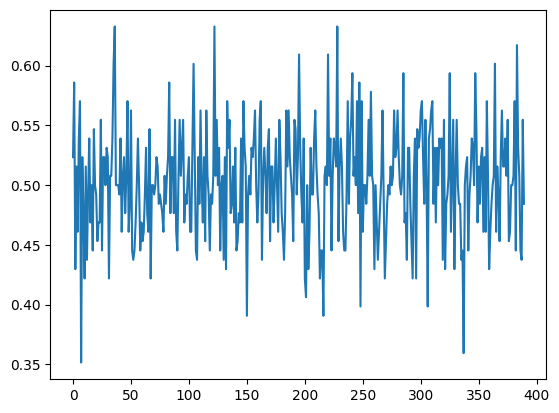

In [52]:
plt.plot(acc_log)

In [ ]:
import matplotlib.pyplot as plt

iter = 300
i = 8

outputs, idxs = outputs_log[iter]
pred = preds_log[iter][i]

dataset_idx = idxs[i]
sentence = X_train[dataset_idx]
label = Y_train[dataset_idx]
print(label, pred)
sentence = [vocab[i] for i in sentence]

weights = outputs['scores'][i]

fig, axes = plt.subplots(1,1, figsize=(15,15))

plt.imshow(weights, cmap='viridis', origin='lower')
plt.colorbar()
plt.xticks(ticks=np.arange(SEQUENCE_LENGTH), labels=sentence, rotation=45)
plt.yticks(ticks=np.arange(SEQUENCE_LENGTH), labels=sentence, rotation=45)
plt.show()

IndexError: list index out of range

### References:

1. Bahdanau et al. 2015
2. Rocktashel et al. 2016 Reasoning about Entailment with Neural Attention ()
3. Parikh, A Decomposable Attention Model for Natural Language Inference
4. GloVe, Pennington et al. (2014)
5. Lin et al. A Structured Self-Attentive Sentence Embedding
6. GloVe Embeddings